In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import linear_model
from sklearn import datasets
from PIL import Image
%matplotlib inline

# 辞書の探求

#### ランダムな辞書を生成

In [161]:
A0 = np.random.randn(30, 60) ## 次元数 30, 辞書数60
A0 = A0 @ np.diag(1 / np.sqrt(np.diag(A0.T @ A0)))

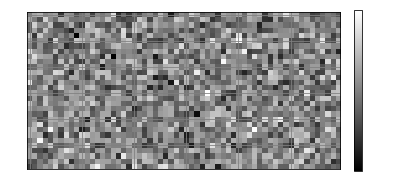

In [162]:
plt.imshow(A0, cmap='gray', interpolation='Nearest')
plt.colorbar(fraction=0.024, pad=0.04)

#### 信号事例を生成

In [163]:
y = np.zeros((30, 4000)) ## 次元数30, データ数4000
sig = 0.1
k0 = 4
for i in range(4000):
    y[:,i] = A0[:, np.random.permutation(range(60))[:k0]] @ np.random.randn(k0) + np.random.randn(30)*sig

<BarContainer object of 30 artists>

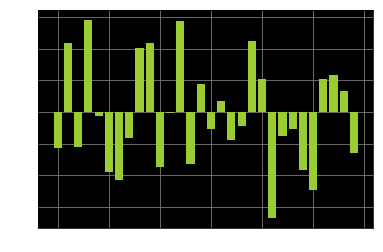

In [164]:
plt.bar(range(30), y[:,1])

In [165]:
def OMP(X, y, k0=4, tol=1e-4):

    if y.ndim != 2:
        y = y.reshape(-1,1)
    
    theta = np.zeros([X.shape[1],1])
    
    S = np.zeros(X.shape[1], dtype=np.uint8)
    r = y.copy()
    rr = r.T @ r
    for _ in range(k0):
        err = rr - (X[:, S==0].T @ r)**2
        ndx = np.where(S==0)[0]
        S[ndx[err.argmin()]] = 1
        Xs = X[:, S==1]
        pinv = np.linalg.pinv(Xs @ Xs.T)
        theta[S==1] = (Xs.T @ (pinv @ y)).reshape(-1,1)
        r = y - (X @ theta)
        rr = r.T @ r
        if rr < tol:
            break
    
    return theta.flatten(), S

In [166]:
def percent_recovery_of_atoms(A, A0, threshold=0.99):
    """ アトムの復元率を測る """
    num = 0
    for m in range(A.shape[1]):
        a = A0[:, m]
        if np.abs(np.dot(a, A)).max() > threshold:
            num += 1
    return float(num) / A.shape[1] * 100

In [167]:
def MOD(X, y, D, k0, tol=1e-4, n_iter=50, D0=None):
    log = []
    for n in range(n_iter):
        for i in range(Y.shape[1]): ## データごとに処理
            X[:,i], _ = OMP(D, y[:,i], k0=k0, tol=tol)
        opt = np.abs( y - D @ X).mean()
        XXTinv = np.linalg.pinv(X@X.T)
        D = y @ (X.T @ XXTinv)
        D = D @ np.diag(1.0 / np.sqrt(np.diag(D.T @ D))) ## 正規化
        
        if A0 is not None:
            opt2 = percent_recovery_of_atoms(D, D0)
            log.append((opt, opt2))
        else:
            log.append(opt)
        print(n, log[n])
    
    return D, np.array(log)
        

In [168]:
D = y[:, :A0.shape[1]]
D = D @ np.diag(1.0 / np.sqrt(np.diag( D.T @ D)))
X = np.zeros([D.shape[1], y.shape[1]]) ## 辞書数 x データ数

In [169]:
A_MOD, log_MOD = MOD(X, y, D, k0=k0, D0=A0)

0 (0.1535073906909208, 0.0)
1 (0.13387920149544683, 0.0)
2 (0.12289082007182821, 0.0)
3 (0.11406531237964511, 6.666666666666667)
4 (0.1071639162726967, 13.333333333333334)
5 (0.10154248015771486, 26.666666666666668)
6 (0.09642886586810777, 41.66666666666667)
7 (0.09142144787047424, 53.333333333333336)
8 (0.08706080780473291, 61.66666666666667)
9 (0.08385941599305483, 68.33333333333333)
10 (0.08144817881300126, 73.33333333333333)
11 (0.07954031329836689, 78.33333333333333)
12 (0.07776889188273912, 81.66666666666667)
13 (0.07589790342089395, 83.33333333333334)
14 (0.0744670604405061, 83.33333333333334)
15 (0.07361700451398129, 86.66666666666667)
16 (0.07314225659106091, 86.66666666666667)
17 (0.07271962670739217, 88.33333333333333)
18 (0.07232728638016926, 93.33333333333333)
19 (0.0721163711086215, 93.33333333333333)
20 (0.07195514850649867, 95.0)
21 (0.07179888819480978, 95.0)
22 (0.0717302639427724, 95.0)
23 (0.07166999761871715, 95.0)
24 (0.07167908137903975, 95.0)
25 (0.0716762597010

Text(0.5,0,'iteration')

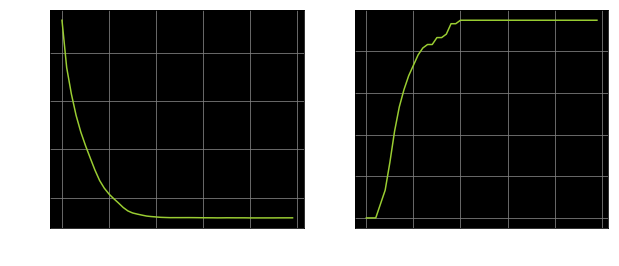

In [288]:
figs, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(log_MOD[:,0])
axs[0].set_ylabel("average error")
axs[0].set_xlabel("iteration")
axs[1].plot(log_MOD[:,1])
axs[1].set_ylabel("correct atom ratio")
axs[1].set_xlabel("iteration")


In [247]:
X0 = np.zeros([D.shape[1], y.shape[1]]) ## 辞書数 x データ数
for i in range(Y.shape[1]): ## データごとに処理
    X0[:,i], _ = OMP(A_MOD, y[:,i], k0=k0, tol=1e-4)

In [277]:
from sklearn.linear_model import Lasso
X1 = np.zeros([D.shape[1], y.shape[1]]) ## 辞書数 x データ数
lasso = Lasso(alpha=0.005, max_iter=1000, tol=1e-4)
for i in range(Y.shape[1]): ## データごとに処理
    lasso.fit(A_MOD, y[:,i])
    X1[:,i] = lasso.coef_

In [278]:
y_pred0 = A_MOD @ X0
y_pred1 = A_MOD @ X1

In [279]:
err0 = np.mean((y - y_pred0)**2, axis=0)
err1 = np.mean((y - y_pred1)**2, axis=0)

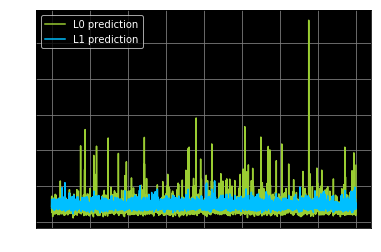

In [280]:
plt.plot(err0, label="L0 prediction")
plt.plot(err1, label="L1 prediction")
plt.legend()

In [282]:
print("L0 predction error = {}".format(np.mean(err0)))
print("L1 predction error = {}".format(np.mean(err1)))

L0 predction error = 0.00830222618563305
L1 predction error = 0.009243158522852492


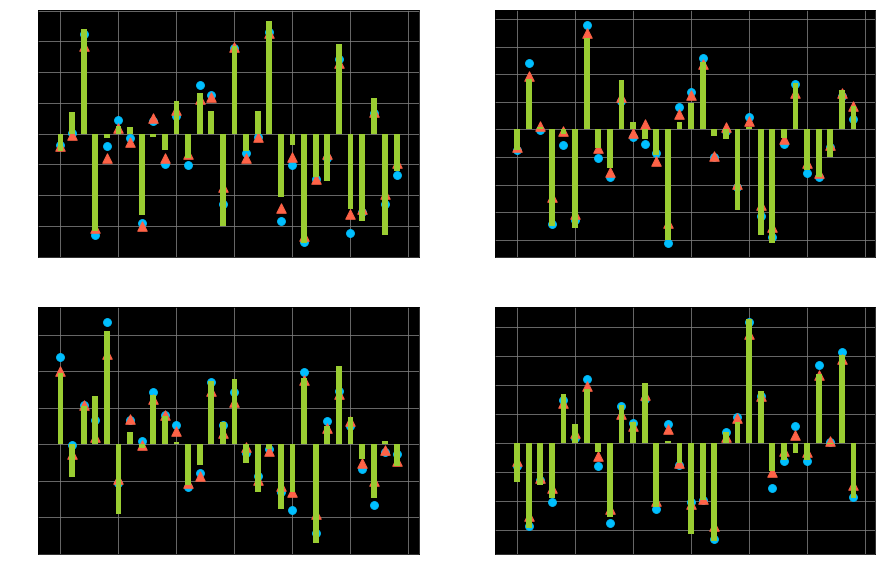

In [286]:
idxs = np.random.permutation(4000)[:4]
figs, axs = plt.subplots(2,2,figsize=(15,10))
for i in range(2):
    for j in range(2):
        axs[i][j].bar(range(30), y[:, idxs[2*i+j]], width=0.5)
        axs[i][j].scatter(range(30), y_pred0[:,idxs[2*i+j]], marker="o", s=60)
        axs[i][j].scatter(range(30), y_pred1[:,idxs[2*i+j]], marker="^", s=90)